In [3]:
import pandas as pd
from xbbg import blp
import numpy as np
import matplotlib.pyplot as plt
import pytz
import time
from datetime import datetime, timedelta, date
from ipywidgets import HBox, RadioButtons, Button, Output
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.gridspec as gridspec
%matplotlib inline
import blpapi
from pydataquery import DataQuery
import warnings
from blpapi import SessionOptions, Session, Request, CorrelationId
import threading
from concurrent.futures import ThreadPoolExecutor
import statsmodels.api as sm
import uuid

import os
import win32com.client
import matplotlib.pyplot as plt
from io import BytesIO
import base64

# warnings.filterwarnings("ignore")

In [4]:
labels = {
        "FR": "DB(CBN,FRF,10,MIDYLD)",
        "DE": "DB(CBN,DEM,10,MIDYLD)",
        "IT": "DB(CBN,ITL,10,MIDYLD)",
}

dq = DataQuery(
client_id='jbAIMF2Tkp0JO3sc',
client_secret='d7qfzgt55pddjs352sgxosFyI4t2eja07k7opbi6wg9oqjc1OjkdAksn1btmnugeMjchcx2vwTsJupw',
)

job = dq.create_job(expressions = list(labels.values()))
dq.start_date = "2021-1-1"
var = job.execute()
df = job.to_pivot_table()
df = df.T
df.index = pd.to_datetime(df.index, format='%Y%m%d').date
df.index.name = 'Date'

df.rename(columns={v:k for k, v in labels.items()},inplace=True)
df.columns.name = None
clear_output(wait=False)
df = df.dropna(how='all')
df = df.dropna(axis=1, how='all')
df

,DE,FR,IT
Date,,,
2021-01-04,-0.604223,-0.368137,0.551251
2021-01-05,-0.589140,-0.347315,0.563259
2021-01-06,-0.521888,-0.321912,0.562974
2021-01-07,-0.517226,-0.314412,0.557252
2021-01-08,-0.521518,-0.318740,0.527722
...,...,...,...
2025-09-03,2.746489,3.547346,3.645784
2025-09-04,2.723215,3.572859,3.606150
2025-09-05,2.660760,3.515096,3.526149


<Axes: xlabel='Date'>

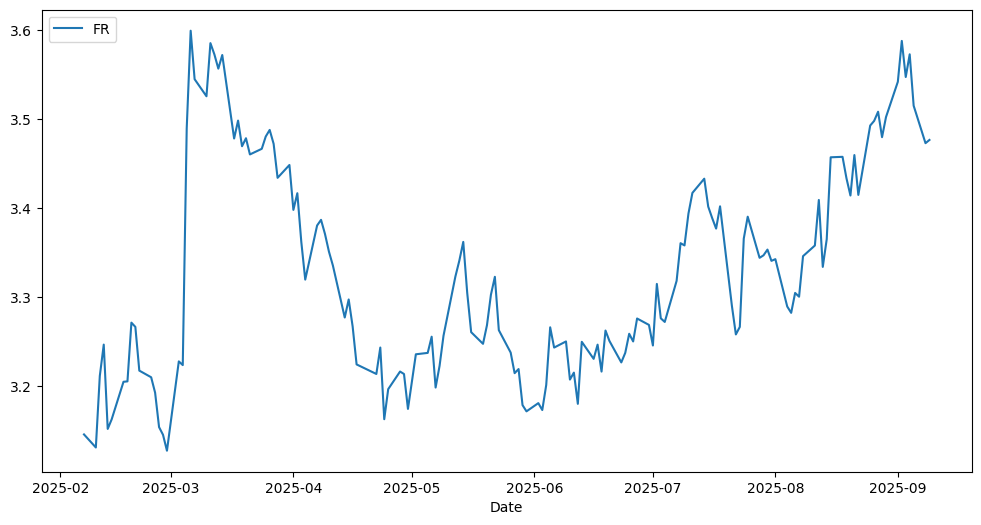

In [10]:
df["OAT Sprd"] = df["FR"] - df["DE"]
df["BTP Sprd"] = df["IT"] - df["DE"]
df1 = df.copy()
# df1[["OAT Sprd","BTP Sprd"]].iloc[-1500:].plot(figsize=(12,6))
df1[["FR"]].iloc[-150:].plot(figsize=(12,6))

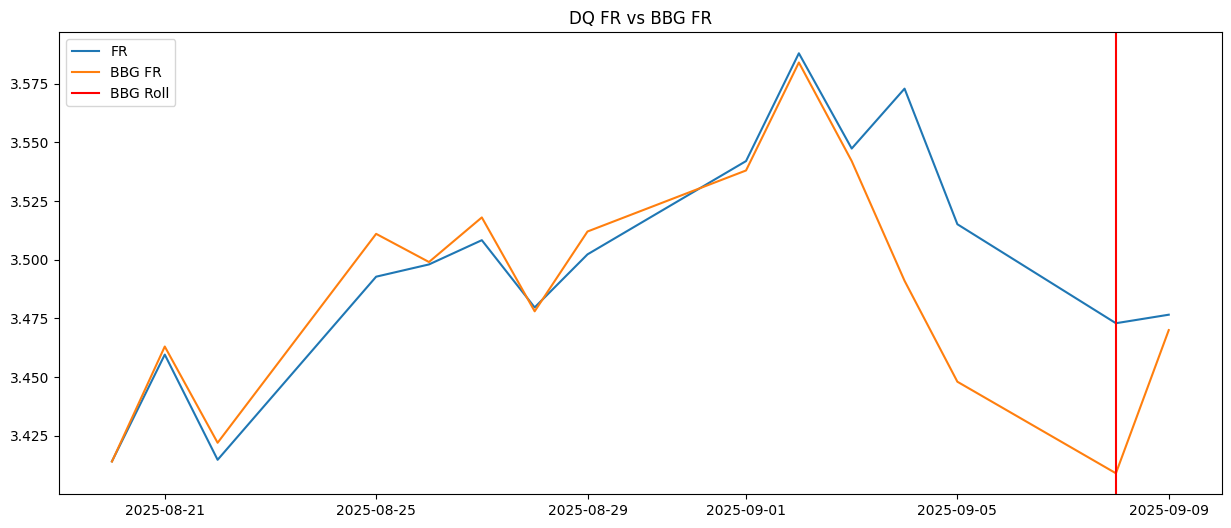

In [27]:
# bbg=blp.bdh(tickers=["GFRN10 Index","GBTPGR10 Index","GDBR10 Index"], flds="PX_LAST", start_date="2021-01-01")
# bbg.columns = ["BBG FR","BBG IT","BBG DE"]
bbg1 = bbg.copy()
# bbg1.index = pd.to_datetime(bbg1.index)
c = pd.concat([df,bbg1],axis=1).sort_index().dropna().copy()
c[["FR","BBG FR"]].iloc[-15:].plot(figsize=(15,6))
plt.title("DQ FR vs BBG FR")
plt.axvline(x=pd.to_datetime("2025-09-08").date(),color="red",label="BBG Roll")
plt.legend()
plt.show()

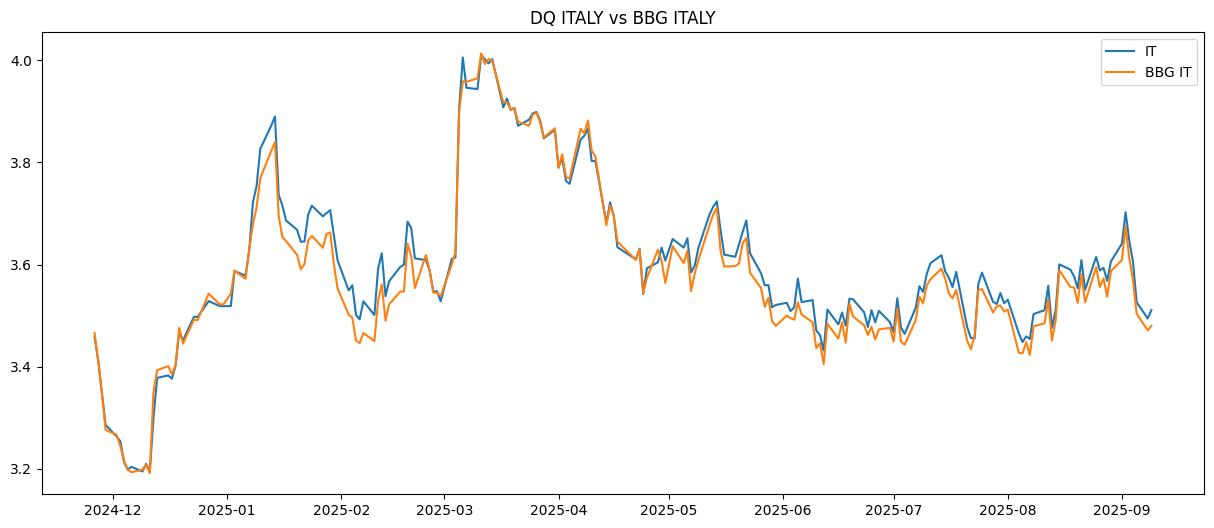

In [19]:
c[["IT","BBG IT"]].iloc[-200:].plot(figsize=(15,6))
plt.title("DQ ITALY vs BBG ITALY")
plt.show()

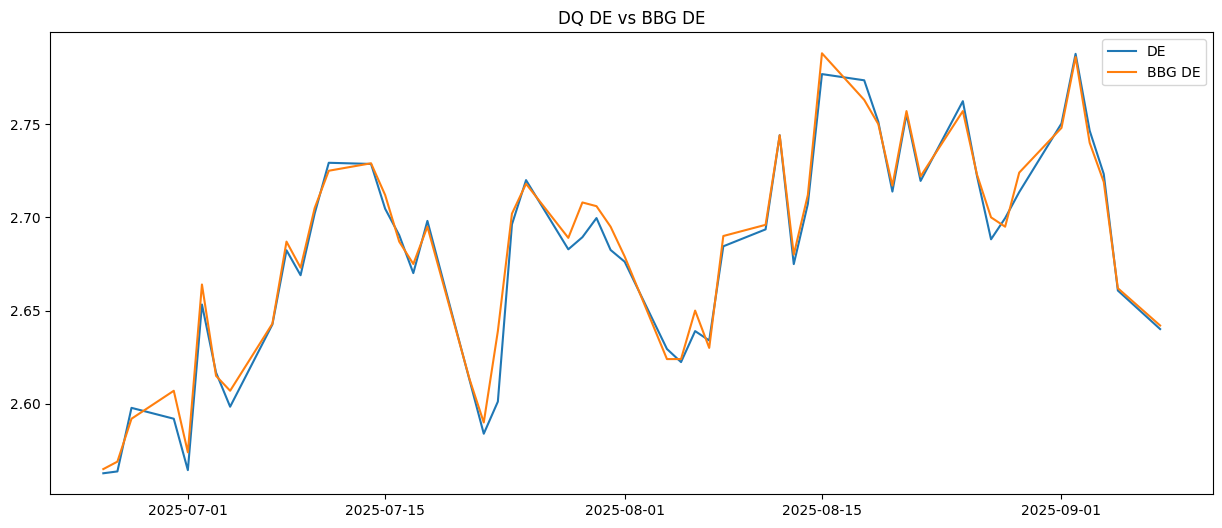

In [53]:
c[["DE","BBG DE"]].iloc[-55:-1].plot(figsize=(15,6))
plt.title("DQ DE vs BBG DE")
plt.show()

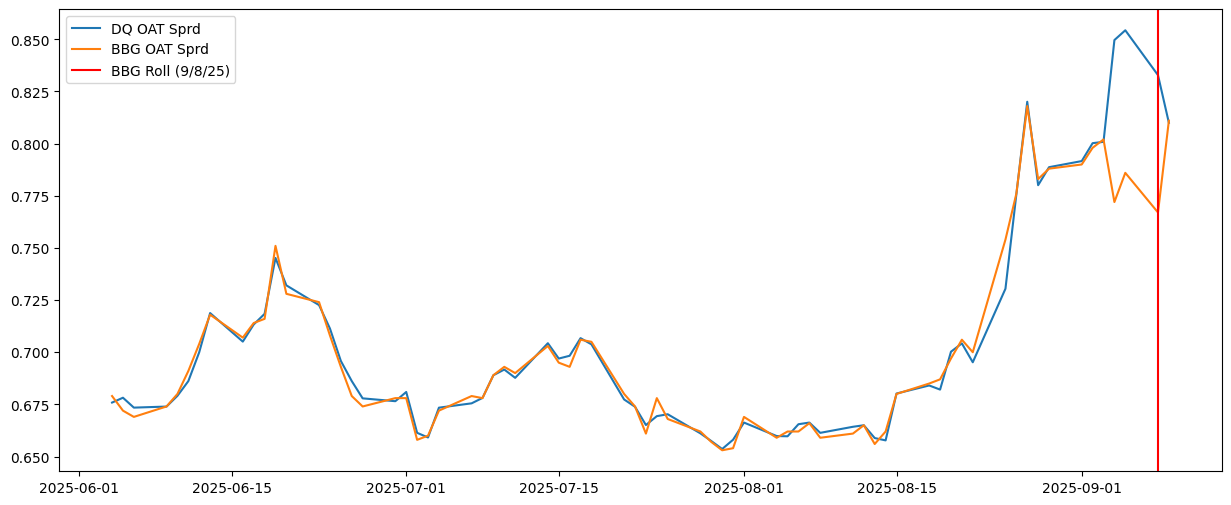

In [41]:
ax=(c["FR"]-c["DE"]).iloc[-70:].plot(figsize=(15,6),label="DQ OAT Sprd")
(c["BBG FR"]-c["BBG DE"]).iloc[-70:].plot(ax=ax,label="BBG OAT Sprd")
# plt.title("DQ DE vs BBG DE")
plt.axvline(x=pd.to_datetime("2025-09-08").date(),color="red",label="BBG Roll (9/8/25)")
plt.legend()
plt.show()

In [52]:
d = c.copy()
d["DQ OAT Sprd"] = c["FR"]-c["DE"]
d["BBG OAT Sprd"] = c["BBG FR"]-c["BBG DE"]
d = d[["FR","DE","DQ OAT Sprd","BBG FR","BBG DE","BBG OAT Sprd"]].copy()
# d[["DQ OAT Sprd","BBG OAT Sprd"]].iloc[-15:]
d.iloc[-15:]
    

,FR,DE,DQ OAT Sprd,BBG FR,BBG DE,BBG OAT Sprd
2025-08-20,3.414074,2.713823,0.700251,3.414,2.717,0.697
2025-08-21,3.459558,2.755320,0.704238,3.463,2.757,0.706
2025-08-22,3.414742,2.719557,0.695185,3.422,2.722,0.700
2025-08-25,3.492754,2.762316,0.730438,3.511,2.757,0.754
2025-08-26,3.497971,2.722284,0.775687,3.499,2.723,0.776
2025-08-27,3.508301,2.688231,0.820071,3.518,2.700,0.818
2025-08-28,3.479657,2.699581,0.780076,3.478,2.695,0.783
2025-08-29,3.502262,2.713557,0.788705,3.512,2.724,0.788
2025-09-01,3.542000,2.750367,0.791633,3.538,2.748,0.790
2025-09-02,3.587928,2.787709,0.800220,3.584,2.786,0.798


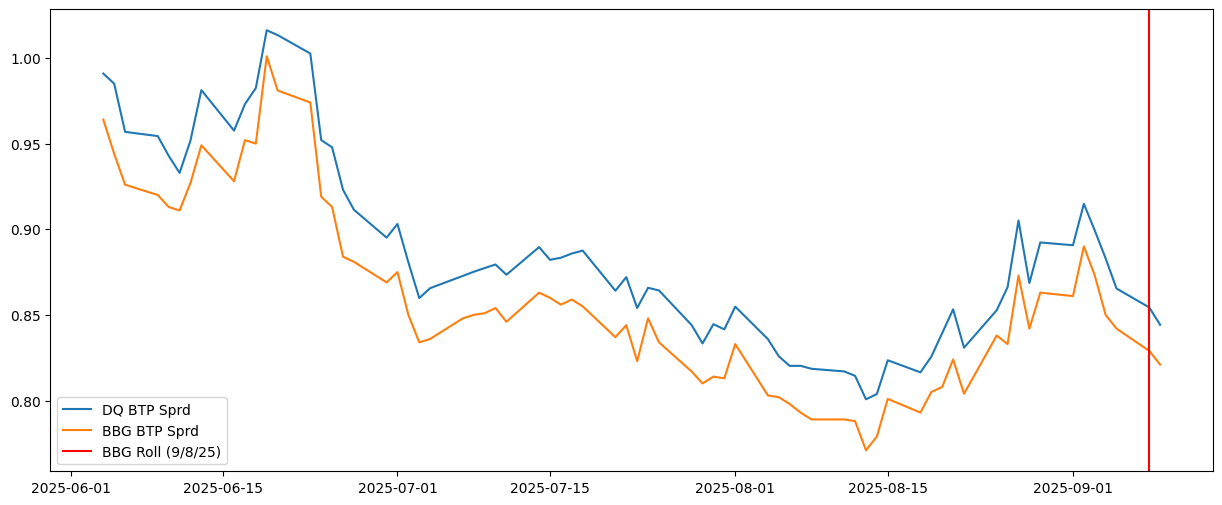

In [43]:
ax=(c["IT"]-c["DE"]).iloc[-70:].plot(figsize=(15,6),label="DQ BTP Sprd")
(c["BBG IT"]-c["BBG DE"]).iloc[-70:].plot(ax=ax,label="BBG BTP Sprd")
# plt.title("DQ DE vs BBG DE")
plt.axvline(x=pd.to_datetime("2025-09-08").date(),color="red",label="BBG Roll (9/8/25)")
plt.legend()
plt.show()

In [2]:
x=blp.bdp(tickers=["CDX IG CDSI GEN 5Y CORP","ITRX EUR CDSI GEN 5Y CORP"], flds="ROLLING_SERIES").copy()
ig=x.iloc[0,0]
main =x.iloc[1,0]
ig_series = f"CDX IG CDSI S{ig} 5Y CORP"
main_series = f"ITRX EUR CDSI S{main} 5Y CORP"

df = pd.read_excel("BBG Data.xlsx",index_col=0, parse_dates=True)
bbg_datafile = df.copy()
last_update = df.dropna().index[-1]
all_bbg_tickers = [ig_series, main_series, "V2X INDEX", "VIX INDEX", 'GBTPGR10 Index', 'GFRN10 Index', 'GDBR10 Index']
new_data = pd.DataFrame()

for bbg_tickers in all_bbg_tickers:
    bbg_date = pd.to_datetime(last_update.date())
    data = None
    while True:
        try:
            f = blp.bdib(ticker = bbg_tickers, dt = bbg_date, interval = 1, ref='IndexYieldCurve')      
        except:
            if bbg_date > pd.to_datetime(datetime.now().date()):
                break
        data = pd.concat([data,f])
        bbg_date += timedelta(days=1)    
    try:
        data = data.iloc[:,[3]].copy()
        data.columns = [bbg_tickers]
    except:
        continue
    new_data = pd.concat([new_data, data],axis=1)

new_data.index = new_data.index.tz_convert('America/New_York')
new_data.index = new_data.index.tz_localize(None)
new_data = new_data.dropna(how="all").drop_duplicates().ffill().between_time("07:30","11:59")
new_data.columns = ["IG","Main","V2X", "VIX", "BTP","OAT","Bund"]
df = pd.concat([df, new_data]).drop_duplicates().sort_index().ffill().copy()
df.to_excel("BBG Data.xlsx")

In [3]:
df = pd.read_excel("BBG Data.xlsx", index_col=0, parse_dates=True)
email_df = df.copy()
email_df["Actual Main-IG"] = email_df["Main"] - email_df["IG"]
email_df["V2X - VIX"] = email_df["V2X"] - email_df["VIX"]
email_df["Sov_Avg"] = 0.5*(email_df["BTP"] + email_df["OAT"] - 2*email_df["Bund"])
email_df = email_df[["Actual Main-IG","V2X - VIX","Sov_Avg"]].copy()
email_df

,Actual Main-IG,V2X - VIX,Sov_Avg
2024-08-07 07:30:00,4.659,-1.9539,1.0905
2024-08-07 07:31:00,4.547,-2.0003,1.0910
2024-08-07 07:32:00,4.455,-2.0972,1.0920
2024-08-07 07:33:00,4.441,-2.0993,1.0920
2024-08-07 07:34:00,4.470,-2.0478,1.0910
...,...,...,...
2025-09-10 11:57:00,3.407,1.9783,0.8130
2025-09-10 11:58:00,3.402,1.9783,0.8130
2025-09-10 11:58:00,3.402,2.0283,0.8130
2025-09-10 11:59:00,3.405,1.9783,0.8125


In [15]:
email_df

,Actual Main-IG,V2X - VIX,Sov_Avg
2024-08-07 07:30:00,4.659,-1.9539,1.0905
2024-08-07 07:31:00,4.547,-2.0003,1.0910
2024-08-07 07:32:00,4.455,-2.0972,1.0920
2024-08-07 07:33:00,4.441,-2.0993,1.0920
2024-08-07 07:34:00,4.470,-2.0478,1.0910
...,...,...,...
2025-09-10 11:57:00,3.407,1.9783,0.8130
2025-09-10 11:58:00,3.402,1.9783,0.8130
2025-09-10 11:58:00,3.402,2.0283,0.8130
2025-09-10 11:59:00,3.405,1.9783,0.8125


In [4]:
########################################## Regression coefs calculations
period = 120 ############# it is only for calculating the daily coefs

all_data = df[["IG","Main","VIX","V2X"]].copy()
all_data = all_data[all_data.index>=datetime.now()-timedelta(days=period)]
all_data = all_data.sort_index().resample("15min").last().drop_duplicates()
all_data.index = all_data.index.tz_localize(None)
all_data.index.name = 'Date'

df = all_data.copy()
df.columns = ["IG","Main","VIX","V2X"]
df_ig = df[["IG"]].copy()
df_hy = df[["Main"]].copy()
df_vix = df[["VIX"]].copy()
df_v2x = df[["V2X"]].copy()
ig_price = df["IG"].iloc[-1]
main_price = df["Main"].iloc[-1]

df = pd.concat([df_ig, df_hy, df_vix, df_v2x], axis=1)
df.dropna(inplace=True)
df['Main-IG'] = df['Main'] - df['IG']
df['V2X - VIX'] = df['V2X'] - df['VIX']
df.drop(['Main','IG','V2X','VIX'], axis=1, inplace=True)

df1 = df[df.index.strftime('%H:%M:%S') == '11:15:00']
df1 = df1.copy()
df1.index = df1.index.date

security = ['GTITL10Y GOVT', 'GTFRF10Y GOVT', 'GTDEM10Y GOVT']
end_date = datetime.now().strftime('%Y-%m-%dT%H:%M:%S')
start_date = (datetime.now() - timedelta(days=period)).strftime('%Y-%m-%dT%H:%M:%S')

df_sov = blp.bdh(tickers=[security[0], security[1],security[2]], flds='PX_LAST', start_date=start_date, end_date=end_date )
df_sov.columns = ['_'.join(col) for col in df_sov.columns]

df_sov.columns = ['BTP','OAT','Bund']
df_sov['Sov_Avg'] = 0.5 * ( df_sov['BTP'] + df_sov['OAT'] - 2 * df_sov['Bund'] )
test2 = df_sov.copy()
df_sov.drop(['BTP','OAT','Bund'], axis=1, inplace=True)

df = pd.concat([df1, df_sov],axis=1)
df.sort_index(inplace=True)
df.dropna(inplace=True)
t = df.copy()
df = df.diff(5)
df.dropna(inplace=True)

y = df.iloc[:, 0]
X = df.iloc[:, 1:3]
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
# print(model.summary())

const_col = 'const'
indep_col1 = df.columns[1]
indep_col2 = df.columns[2]

coefficients = model.params
constant = coefficients[const_col]
coef_col2 = coefficients[indep_col1]
coef_col3 = coefficients[indep_col2]

y_pred = model.predict(X)
dif = (y-y_pred)
dif_std = dif.std()
dif_mean = dif.mean()

In [5]:
######################### Live prices not needed for email
# def get_live_price(security):
#     session = blpapi.Session()
#     if not session.start():
#         print("Failed to start session.")
#         exit()
    
#     if not session.openService("//blp/refdata"):
#         print("Failed to open //blp/refdata")
#         exit()
    
#     refDataService = session.getService("//blp/refdata")
#     request = refDataService.createRequest("IntradayBarRequest")
    
#     start_time = datetime.now() - timedelta(days = 5)
#     end_time = datetime.now() + timedelta(days = 1)
    
#     request.set("security", security)
#     request.set("eventType", "TRADE")
#     request.set("interval", 1) 
#     request.set("startDateTime", start_time.strftime("%Y-%m-%dT%H:%M:%S"))
#     request.set("endDateTime", end_time.strftime("%Y-%m-%dT%H:%M:%S"))
    
#     session.sendRequest(request)
    
#     data = []
#     while True:
#         ev = session.nextEvent()
#         for msg in ev:
#             if msg.hasElement("barData"):
#                 barData = msg.getElement("barData").getElement("barTickData")
#                 for i in range(barData.numValues()):
#                     bar = barData.getValueAsElement(i)
#                     data.append({
#                         "time": bar.getElementAsDatetime("time"),
#                         "close": bar.getElementAsFloat("close"),
#                     })
#         if ev.eventType() == blpapi.Event.RESPONSE:
#             break

#     df = pd.DataFrame(data)
#     df.columns = ['Date',f'{security}']
#     df['Date'] = pd.to_datetime(df['Date'])
#     df.set_index('Date',inplace=True)
#     df.index = df.index.tz_localize('UTC').tz_convert('America/New_York')
#     return df.copy()
    
# security = [ig_series, main_series, 'V2X Index', 'VIX Index', 'GTITL10Y GOVT', 'GTFRF10Y GOVT', 'GTDEM10Y GOVT']

# df_ig = get_live_price(security[0])
# df_main = get_live_price(security[1])
# df_v2x = get_live_price(security[2])
# df_vix = get_live_price(security[3])
# df_btp = get_live_price(security[4])
# df_oat = get_live_price(security[5])
# df_bund = get_live_price(security[6])
# df = pd.concat([df_ig, df_main, df_v2x, df_vix, df_btp, df_oat, df_bund],axis=1)
# df.dropna(inplace=True)

# def get_yield_cds(df, ticker, output_field, override_field):
#     start_time = time.time()
#     sessionOptions = SessionOptions()
#     sessionOptions.setServerHost('localhost')
#     sessionOptions.setServerPort(8194)
#     session = Session(sessionOptions)
#     if not session.start():
#         print("Failed to start session.")
#         exit()
#     if not session.openService("//blp/refdata"):
#         print("Failed to open //blp/refdata")
#         exit()
#     refDataService = session.getService("//blp/refdata")
#     results = {}
#     correlation_id_to_px = {}
#     pending_requests = set()   
#     def send_requests(px_list):
#         for idx, px in px_list:
#             request = refDataService.createRequest("ReferenceDataRequest")
#             request.getElement("securities").appendValue(ticker)
#             request.getElement("fields").appendValue(output_field)
#             overrides = request.getElement("overrides")
#             override = overrides.appendElement()
#             override.setElement("fieldId", override_field)
#             override.setElement("value", str(px))
#             cid = CorrelationId(uuid.uuid4())
            
#             correlation_id_to_px[cid] = {'idx': idx, 'px': px}
#             pending_requests.add(cid)
#             session.sendRequest(request,correlationId=cid)
#     def event_loop():
#         while pending_requests:
#             ev = session.nextEvent()
#             for msg in ev:
#                 if msg.correlationIds():
#                     cid = msg.correlationIds()[0]
#                     data = correlation_id_to_px.get(cid)
#                     if data is not None:
#                         idx = data['idx']
#                         px = data['px']
#                         if idx not in results:
#                             results[idx] ={'px': px, 'fieldData_list': []}
#                         if msg.hasElement("securityData"):
#                             securityDataArray = msg.getElement("securityData")
#                             for securityData in securityDataArray.values():
#                                 fieldData = securityData.getElement("fieldData")
#                                 results[idx]['fieldData_list'].append(fieldData)
#                     pending_requests.discard(cid)
                    
#     px_values = list(zip(df.index.tolist(), df[ticker].tolist()))
#     send_requests(px_values)
#     event_loop()
#     output_rows = []
#     for idx in sorted(results.keys()):
#         data = results[idx]
#         px = data['px']
#         fieldData_list = data['fieldData_list']
#         for fieldData in fieldData_list:
#             if fieldData.hasElement(output_field):
#                 yield_value = fieldData.getElementAsFloat(output_field)
#                 output_rows.append({'Index': idx, 'Price':px, 'Yield':yield_value})
#             else:
#                 output_rows.append({'Index': idx, 'Price':px, 'Yield': None})
#     output_df = pd.DataFrame(output_rows)
#     output_df.set_index('Index',inplace=True)
#     output_df.sort_index(inplace=True)
#     output_df.drop(['Price'],axis=1,inplace=True)
#     output_df.columns = [f'{ticker} YLD']
#     output_df.index.name = 'Date'
#     session.stop()
#     return output_df

# df_check = get_yield_cds(df, security[4],'YAS_BOND_YLD','YAS_BOND_PX')
# df_check1 = get_yield_cds(df, security[5],'YAS_BOND_YLD','YAS_BOND_PX')
# df_check2 = get_yield_cds(df, security[6],'YAS_BOND_YLD','YAS_BOND_PX')

# df = pd.concat([df,df_check,df_check1,df_check2],axis=1)
# df.drop([security[4],security[5],security[6]],axis=1,inplace=True)
# df.columns = df.columns.str.replace(" YLD", "")

# df['Sov_Avg'] = 0.5 * (df['GTITL10Y GOVT'] + df['GTFRF10Y GOVT'] - 2 * df['GTDEM10Y GOVT'])
# df.drop([security[4],security[5],security[6]],axis=1,inplace=True)
# df['V2X - VIX'] = df['V2X Index'] - df['VIX Index']
# df['Actual Main-IG'] = df.iloc[:,1] - df.iloc[:,0]
# df.drop([security[0],security[1]],axis=1,inplace=True)
# df = df[['Actual Main-IG','V2X - VIX','Sov_Avg']]

# fields = ['PX_LAST','PX_LAST','PX_LAST','PX_LAST','YAS_BOND_YLD','YAS_BOND_YLD','YAS_BOND_YLD']

# def get_prices():
#     def create_session():
#         session_options = blpapi.SessionOptions()
#         session_options.setServerHost('localhost')
#         session_options.setServerPort(8194)
#         session = blpapi.Session(session_options)
#         if not session.start():
#             print("Failed to start session.")
#             return None
#         if not session.openService("//blp/refdata"):
#             print("Failed to open //blp/refdata")
#             return None
#         return session
    
#     def fetch_data(session, tickers, fields):
#         service = session.getService("//blp/refdata")
#         correlation_id_to_info = {}
#         pending_requests = set()
#         data = {}

#         for ticker, field in zip(tickers,fields):
#             request = service.createRequest("ReferenceDataRequest")
#             request.getElement("securities").appendValue(ticker)
#             request.getElement("fields").appendValue(field)
        
#             cid = blpapi.CorrelationId(uuid.uuid4())
#             correlation_id_to_info[cid] = {'ticker': ticker, 'field':field}
#             pending_requests.add(cid)
#             session.sendRequest(request, correlationId=cid)

#         while pending_requests:
#             event = session.nextEvent()
#             for msg in event:
#                 if msg.correlationIds():
#                     cid = msg.correlationIds()[0]
#                     if cid in pending_requests:
#                         pending_requests.remove(cid)
#                         info = correlation_id_to_info[cid]
#                         ticker = info['ticker']
#                         field = info['field']
#                         if msg.hasElement("securityData"):
#                             security_data_array = msg.getElement("securityData")
#                             for security_data in security_data_array.values():                                
#                                 field_data = security_data.getElement("fieldData")
#                                 if field_data.hasElement(field):
#                                     data[ticker] = field_data.getElementAsFloat(field)
#                                 else:
#                                     data[ticker] = None
#         return data
 
#     session = create_session()
    
#     data = fetch_data(session, security, fields)
#     session.stop()
#     df = pd.DataFrame(data, index = [0])
#     current_time_florida = datetime.now(pytz.timezone('America/New_York'))
#     df['Timestamp'] = current_time_florida
#     df.set_index('Timestamp', inplace=True)
#     df = df[security]
    
#     return df.copy()

,Actual Main-IG,V2X - VIX,Sov_Avg,t_prev,Actual Main-IG_prev_week,V2X - VIX_prev_week,Sov_Avg_prev_week,Actual Main-IG_diff,V2X - VIX_diff,Sov_Avg_diff
time,,,,,,,,,,
2024-08-07 07:30:00,4.659,-1.9539,1.0905,2024-07-31 07:30:00,NaN,NaN,NaN,NaN,NaN,NaN
2024-08-07 07:31:00,4.547,-2.0003,1.0910,2024-07-31 07:31:00,NaN,NaN,NaN,NaN,NaN,NaN
2024-08-07 07:32:00,4.455,-2.0972,1.0920,2024-07-31 07:32:00,NaN,NaN,NaN,NaN,NaN,NaN
2024-08-07 07:33:00,4.441,-2.0993,1.0920,2024-07-31 07:33:00,NaN,NaN,NaN,NaN,NaN,NaN
2024-08-07 07:34:00,4.470,-2.0478,1.0910,2024-07-31 07:34:00,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2025-09-10 11:57:00,3.407,1.9783,0.8130,2025-09-03 11:57:00,4.348,1.4809,0.8365,-0.941,0.4974,-0.0235
2025-09-10 11:58:00,3.402,1.9783,0.8130,2025-09-03 11:58:00,4.332,1.4609,0.8375,-0.930,0.5174,-0.0245
2025-09-10 11:58:00,3.402,2.0283,0.8130,2025-09-03 11:58:00,4.332,1.4609,0.8375,-0.930,0.5674,-0.0245


,Actual Main-IG,V2X - VIX,Sov_Avg,t_prev,Actual Main-IG_prev_week,V2X - VIX_prev_week,Sov_Avg_prev_week,Actual Main-IG_diff,V2X - VIX_diff,Sov_Avg_diff,Pred. Main-IG_diff
time,,,,,,,,,,,
2024-08-07 07:30:00,4.659,-1.9539,1.0905,2024-07-31 07:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-08-07 07:31:00,4.547,-2.0003,1.0910,2024-07-31 07:31:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-08-07 07:32:00,4.455,-2.0972,1.0920,2024-07-31 07:32:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-08-07 07:33:00,4.441,-2.0993,1.0920,2024-07-31 07:33:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-08-07 07:34:00,4.470,-2.0478,1.0910,2024-07-31 07:34:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2025-09-10 11:57:00,3.407,1.9783,0.8130,2025-09-03 11:57:00,4.348,1.4809,0.8365,-0.941,0.4974,-0.0235,-0.127115
2025-09-10 11:58:00,3.402,1.9783,0.8130,2025-09-03 11:58:00,4.332,1.4609,0.8375,-0.930,0.5174,-0.0245,-0.136786
2025-09-10 11:58:00,3.402,2.0283,0.8130,2025-09-03 11:58:00,4.332,1.4609,0.8375,-0.930,0.5674,-0.0245,-0.124945


<Figure size 640x480 with 0 Axes>

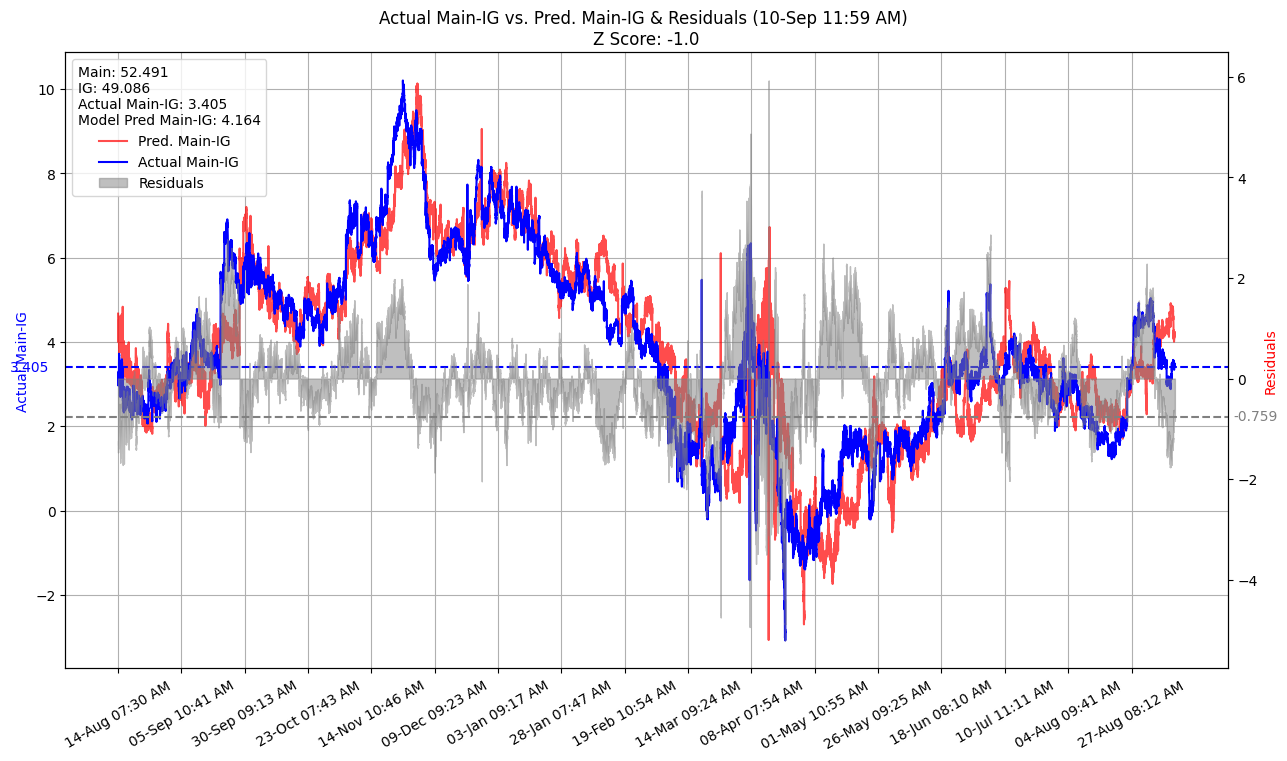

In [6]:
plt.ion()
df = email_df.copy()
buf = BytesIO()

test = pd.DataFrame()

def create_diff(df):
    global test
    df_reset = df.reset_index()
    df_reset.columns = ['time'] + list(df.columns)
    df_reset['t_prev'] = df_reset['time'] - pd.Timedelta(days=7)
    df_prev_values = pd.merge_asof(
        df_reset[['t_prev']].sort_values('t_prev'),
        df_reset[['time'] + list(df.columns)].sort_values('time'),
        left_on='t_prev',
        right_on='time',
        direction ='backward')
    df_combined = pd.concat([df_reset,df_prev_values[df.columns].add_suffix('_prev_week')], axis=1)
    for col in df.columns:
        df_combined[col +'_diff'] = df_combined[col] - df_combined[col+'_prev_week']
    df_combined.set_index('time',inplace=True)
    df_diff = df_combined.copy()
    display(df_diff)
    df_diff['Pred. Main-IG_diff'] = constant + coef_col2 * df_diff['V2X - VIX_diff'] + coef_col3 * df_diff['Sov_Avg_diff']
    display(df_diff)
    df_diff['Pred. Main-IG'] = df_diff['Actual Main-IG_prev_week'] + df_diff['Pred. Main-IG_diff']
    df_diff['Actual - Pred. Main-IG'] = df_diff['Actual Main-IG'] - df_diff['Pred. Main-IG']
    test = df_diff.copy()
    df_diff = df_diff[['Actual Main-IG','Pred. Main-IG','Actual - Pred. Main-IG']].copy()
    df_diff.dropna(inplace=True)
    df_diff.index.name = 'Timestamp'
    df_diff.index = df_diff.index.tz_localize(None)
    return df_diff.copy()

florida_tz=pytz.timezone('America/New_York')
current_time_florida=datetime.now(florida_tz)
start_time_florida=current_time_florida.replace(hour=3,minute=0,second=0,microsecond=0)
end_time_florida=current_time_florida.replace(hour=12,minute=0,second=0,microsecond=0)

dfA = df.copy()

    
df.index.name = 'Date'

dft = dfA.copy()
df = dfA.copy()
df = create_diff(df)

x_end_time = df.index[-1]
x_start_time = df.index[0]
current_time_florida_str = df.index[-1].strftime("%I:%M:%S %p")
if df.index[-1].second!=0:
    df=df.iloc[:-1]
x_ticks = pd.date_range(start=x_start_time, end=x_end_time, freq='60min')
x_labels = [tick.strftime('%I:%M %p') for tick in x_ticks]

recent_main_ig_value = df.iloc[-1]['Actual Main-IG']
y_valuesB =  df['Actual Main-IG']
y_valuesB1 =  df['Actual - Pred. Main-IG']
y_valuesB2 =  df['Actual Main-IG'] - df['Actual - Pred. Main-IG']

recent_diff_value = df.iloc[-1]['Actual - Pred. Main-IG']

zscore = (recent_diff_value - dif_mean)/(dif_std)
x_labelsB = df.index.strftime("%d-%b %I:%M %p")

plt.clf()

fig, ax = plt.subplots(figsize=(15, 8))

ax.plot(range(len(y_valuesB2)), y_valuesB2, color='red', alpha=0.7, linestyle='-', label='Pred. Main-IG')
ax.plot(range(len(y_valuesB)), y_valuesB, color='blue', linestyle='-', label='Actual Main-IG')
stepB = 90*10*5
ax.set_xticks(range(0, len(x_labelsB), stepB))
ax.set_xticklabels(x_labelsB[::stepB], rotation=30)
ax.axhline(y=recent_main_ig_value, color='blue', linestyle='--')#, label='Recent Value')
ax.grid(True, axis='x')
ax.grid(True, axis='y')
ax.set_ylabel('Actual Main-IG', color='blue')

ax_2 = ax.twinx()
ax_2.fill_between(range(len(y_valuesB1)), y_valuesB1, color='gray', alpha=0.5, label='Residuals')
ax_2.set_ylabel('Residuals', color='red')
ax.set_title(f'Actual Main-IG vs. Pred. Main-IG & Residuals ({email_df.index[-1].strftime("%d-%b %I:%M %p")}) \nZ Score: {zscore:.1f}')
# ax.set_title('Main-IG = blue & left; Pred. Main-IG = red & left axis; Residuals = coral & right axis')
ax_2.axhline(y=recent_diff_value, color='gray', linestyle='--')#, label='Current Residual')
ax.text(x=-0.065 * len(x_labelsB), y=recent_main_ig_value, s=f'{recent_main_ig_value:.3f}', color='blue',
        verticalalignment='center', horizontalalignment='right')
ax_2.text(x=1.055 * len(x_labelsB), y=recent_diff_value, s=f'{recent_diff_value:.3f}', color='gray',
         verticalalignment='center', horizontalalignment='left')
handles_ax, labels_ax = ax.get_legend_handles_labels()
handles_ax_2, labels_ax_2 = ax_2.get_legend_handles_labels()
handlesB = handles_ax + handles_ax_2
labelsB = labels_ax + labels_ax_2
ax.legend(handlesB, labelsB, loc='upper left', title=f'Main: {main_price:.3f}\
\nIG: {ig_price:.3f}\nActual Main-IG: {main_price - ig_price:.3f}\
\nModel Pred Main-IG: {main_price - ig_price - recent_diff_value:.3f}')
plt.savefig("Plots.png")    
plt.savefig(buf, format='png')
buf.seek(0)
plt.show()
clear_output(wait=True)


In [7]:
test[["V2X - VIX_diff","Sov_Avg_diff","Pred. Main-IG_diff"]].dropna()

,V2X - VIX_diff,Sov_Avg_diff,Pred. Main-IG_diff
time,,,
2024-08-14 07:30:00,1.3065,-0.0270,0.014077
2024-08-14 07:31:00,1.3431,-0.0280,0.008337
2024-08-14 07:32:00,1.4561,-0.0300,0.006284
2024-08-14 07:33:00,1.5054,-0.0290,0.032367
2024-08-14 07:34:00,1.4649,-0.0285,0.029979
...,...,...,...
2025-09-10 11:57:00,0.4974,-0.0235,-0.127115
2025-09-10 11:58:00,0.5174,-0.0245,-0.136786
2025-09-10 11:58:00,0.5674,-0.0245,-0.124945


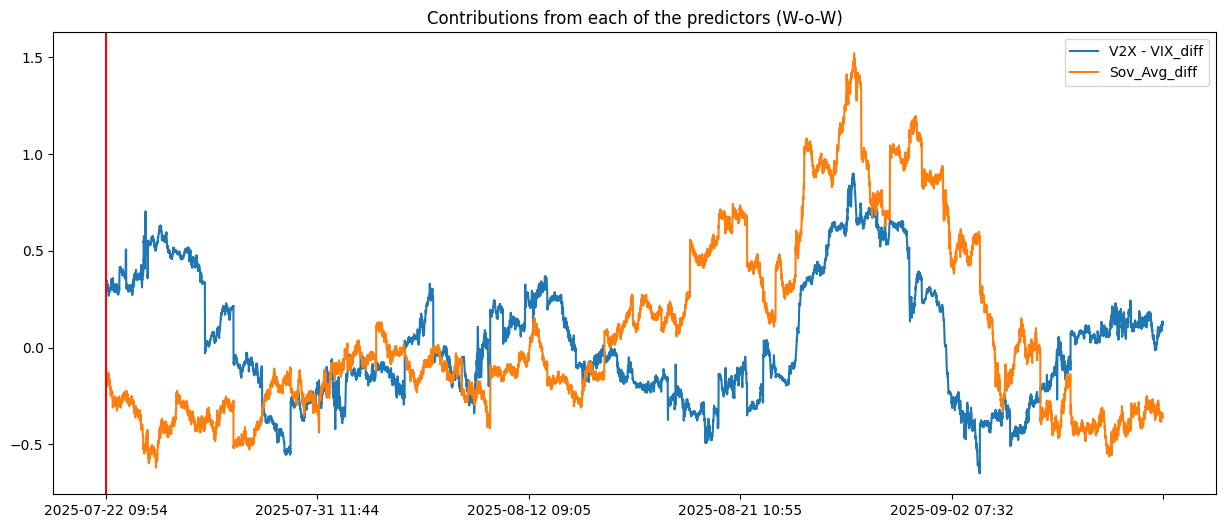

In [26]:
contri = pd.concat([coef_col2 * test['V2X - VIX_diff'], coef_col3 * test['Sov_Avg_diff']],axis=1).dropna()
contri.index = [str(item)[:-3] for item in contri.index ]
contri.iloc[-10000:].plot(figsize=(15,6))
plt.title("Contributions from each of the predictors (W-o-W)")
plt.axvline(x=contri.index[-20],color="red")
plt.show()

In [25]:
contri.index[-2000]

'2025-09-02 07:32'

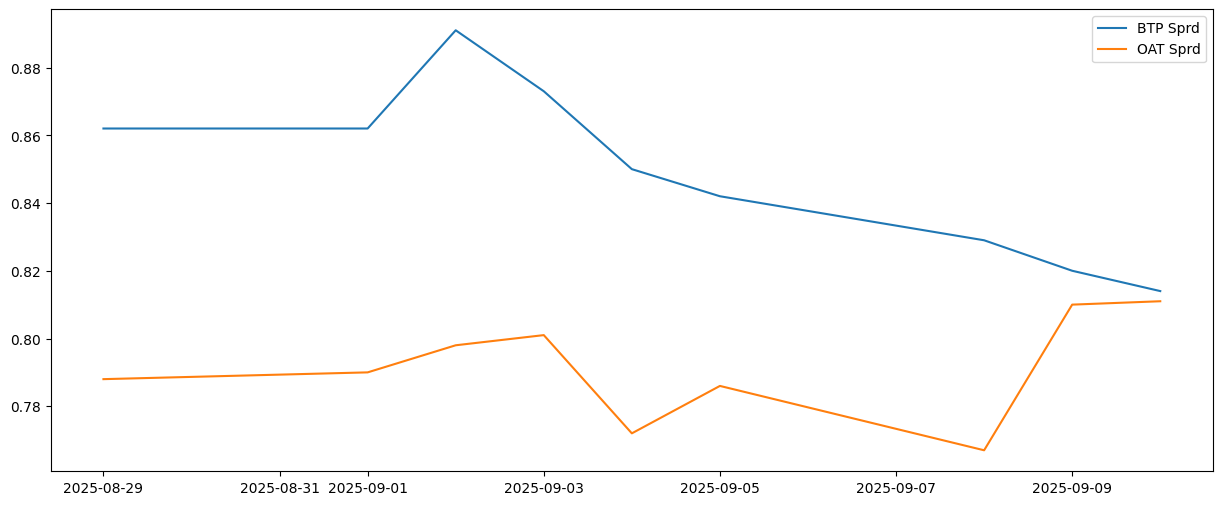

In [18]:
(test2["BTP"] - test2["Bund"]).iloc[-9:].plot(figsize=(15,6),label="BTP Sprd")
(test2["OAT"] - test2["Bund"]).iloc[-9:].plot(label="OAT Sprd")
plt.legend()
plt.show()

In [10]:
test

,Actual Main-IG,V2X - VIX,Sov_Avg,t_prev,Actual Main-IG_prev_week,V2X - VIX_prev_week,Sov_Avg_prev_week,Actual Main-IG_diff,V2X - VIX_diff,Sov_Avg_diff,Pred. Main-IG_diff,Pred. Main-IG,Actual - Pred. Main-IG
time,,,,,,,,,,,,,
2024-08-07 07:30:00,4.659,-1.9539,1.0905,2024-07-31 07:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-08-07 07:31:00,4.547,-2.0003,1.0910,2024-07-31 07:31:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-08-07 07:32:00,4.455,-2.0972,1.0920,2024-07-31 07:32:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-08-07 07:33:00,4.441,-2.0993,1.0920,2024-07-31 07:33:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-08-07 07:34:00,4.470,-2.0478,1.0910,2024-07-31 07:34:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-09-10 11:57:00,3.407,1.9783,0.8130,2025-09-03 11:57:00,4.348,1.4809,0.8365,-0.941,0.4974,-0.0235,-0.127115,4.220885,-0.813885
2025-09-10 11:58:00,3.402,1.9783,0.8130,2025-09-03 11:58:00,4.332,1.4609,0.8375,-0.930,0.5174,-0.0245,-0.136786,4.195214,-0.793214
2025-09-10 11:58:00,3.402,2.0283,0.8130,2025-09-03 11:58:00,4.332,1.4609,0.8375,-0.930,0.5674,-0.0245,-0.124945,4.207055,-0.805055


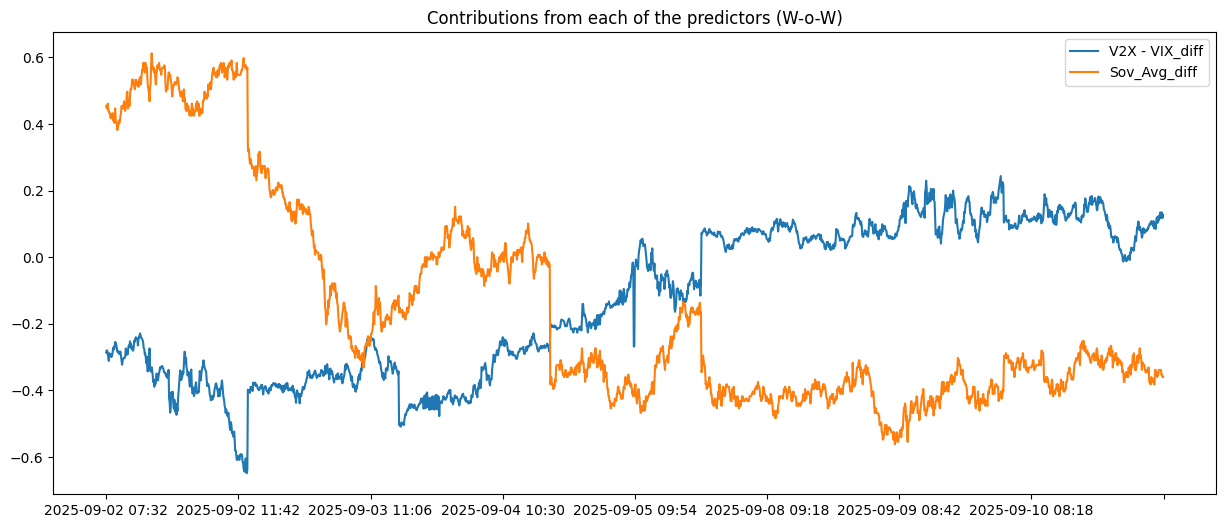

In [11]:
contri = pd.concat([coef_col2 * test['V2X - VIX_diff'], coef_col3 * test['Sov_Avg_diff']],axis=1).dropna()
contri.index = [str(item)[:-3] for item in contri.index ]
contri.iloc[-2000:].plot(figsize=(15,6))
plt.title("Contributions from each of the predictors (W-o-W)")
plt.show()

In [12]:
contri.iloc[[-2000,-1],:]

,V2X - VIX_diff,Sov_Avg_diff
2025-09-02 07:32,-0.286233,0.453846
2025-09-10 11:59,0.127273,-0.360195


In [13]:
contri.iloc[-1]-contri.iloc[-2000]

V2X - VIX_diff    0.413506
Sov_Avg_diff     -0.814041
dtype: float64

In [14]:
t

,Main-IG,V2X - VIX,Sov_Avg
2025-05-14,1.651,-1.1108,0.8470
2025-05-15,1.496,-1.7956,0.8395
2025-05-16,1.579,-1.1800,0.8395
2025-05-19,1.660,-1.6135,0.8400
2025-05-20,1.569,-1.5145,0.8265
...,...,...,...
2025-09-04,3.795,1.7261,0.8110
2025-09-05,3.609,1.6969,0.8140
2025-09-08,3.411,1.8872,0.7980
2025-09-09,2.948,1.4184,0.8150


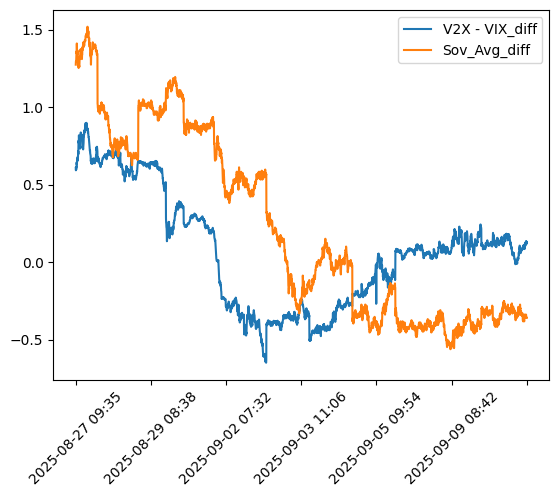

In [32]:
contri.iloc[-3000:].plot()
plt.xticks(rotation=45)
plt.show()

In [34]:
df = pd.read_excel("BBG Data.xlsx", index_col=0, parse_dates=True)
df

,BTP,OAT,Bund,V2X,VIX,Main,IG
2024-08-07 07:30:00,3.717,3.028,2.282,20.6761,22.63,61.868,57.209
2024-08-07 07:31:00,3.717,3.027,2.281,20.7197,22.72,61.853,57.306
2024-08-07 07:32:00,3.717,3.027,2.280,20.7528,22.85,61.866,57.411
2024-08-07 07:33:00,3.716,3.026,2.279,20.7507,22.85,61.870,57.429
2024-08-07 07:34:00,3.716,3.026,2.280,20.7422,22.79,61.884,57.414
...,...,...,...,...,...,...,...
2025-09-10 11:57:00,3.466,3.462,2.651,16.8283,14.85,52.489,49.082
2025-09-10 11:58:00,3.467,3.463,2.652,16.8283,14.85,52.488,49.086
2025-09-10 11:58:00,3.467,3.463,2.652,16.8283,14.80,52.488,49.086
2025-09-10 11:59:00,3.467,3.462,2.652,16.8283,14.85,52.491,49.086


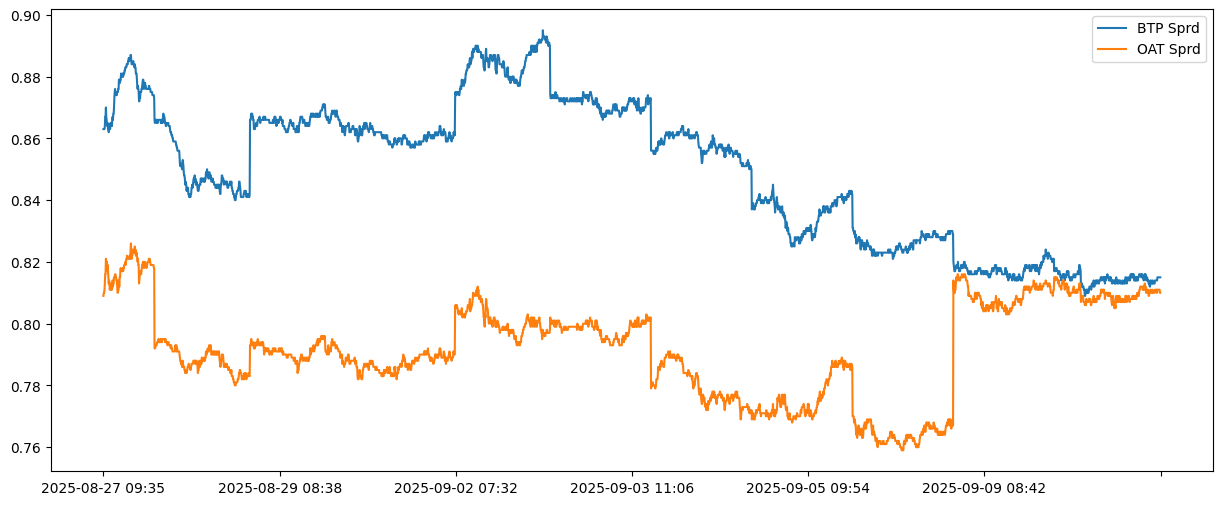

In [42]:
test2 = df.copy()
test2.index = [str(item)[:-3] for item in test2.index]
per = 3000
(test2["BTP"] - test2["Bund"]).iloc[-per:].plot(figsize=(15,6),label="BTP Sprd")
(test2["OAT"] - test2["Bund"]).iloc[-per:].plot(label="OAT Sprd")
plt.legend()
plt.show()

In [71]:
d["Diff"] = d["DQ OAT Sprd"] - d["BBG OAT Sprd"]
d["FR Diff"] = d["FR"] - d["BBG FR"]
d

,FR,DE,DQ OAT Sprd,BBG FR,BBG DE,BBG OAT Sprd,Diff,FR Diff
2021-01-04,-0.368137,-0.604223,0.236086,-0.368,-0.604,0.236,0.000086,-0.000137
2021-01-05,-0.347315,-0.589140,0.241825,-0.338,-0.577,0.239,0.002825,-0.009315
2021-01-06,-0.321912,-0.521888,0.199976,-0.321,-0.520,0.199,0.000976,-0.000912
2021-01-07,-0.314412,-0.517226,0.202815,-0.322,-0.522,0.200,0.002815,0.007588
2021-01-08,-0.318740,-0.521518,0.202778,-0.317,-0.519,0.202,0.000778,-0.001740
...,...,...,...,...,...,...,...,...
2025-09-03,3.547346,2.746489,0.800857,3.542,2.740,0.802,-0.001143,0.005346
2025-09-04,3.572859,2.723215,0.849644,3.491,2.719,0.772,0.077644,0.081859
2025-09-05,3.515096,2.660760,0.854336,3.448,2.662,0.786,0.068336,0.067096
2025-09-08,3.472926,2.640095,0.832831,3.409,2.642,0.767,0.065831,0.063926


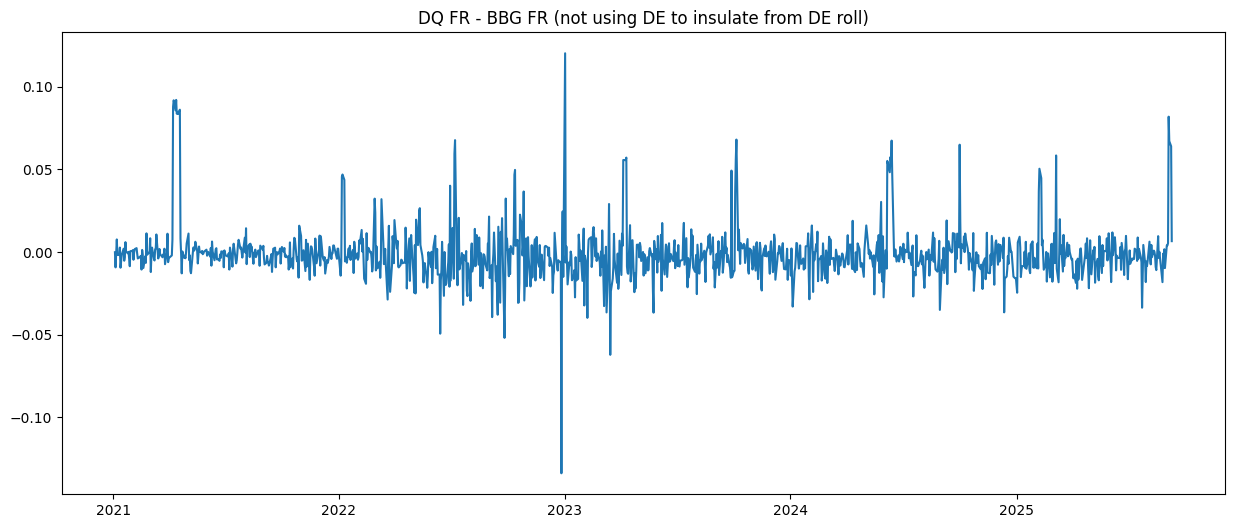

In [79]:
d["FR Diff"].plot(figsize=(15,6))
plt.title("DQ FR - BBG FR (not using DE to insulate from DE roll)")
plt.show()

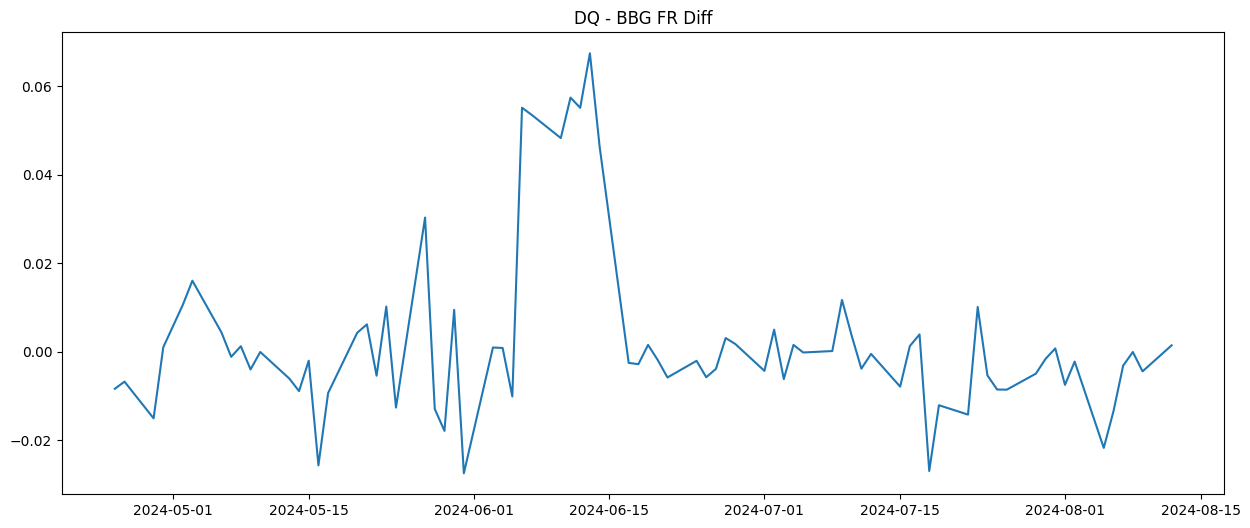

In [84]:
d["FR Diff"].iloc[-352:-275].plot(figsize=(15,6))
plt.title("DQ - BBG FR Diff")
plt.show()